Overall plan:
- Get sampled values from image
- Center image on source peak
- 5 arcsec x 5 arcsec
- Interpolate vertical and horizontal directions to "smooth" image
- Shove into SQL database
- Call this function in make_catalog

In [19]:
from astropy.coordinates import Angle
import astropy.units as u
from astropy.io import fits
from find_source import fits_data_index, summary, significant
import matplotlib.pyplot as plt
import math

In [20]:
significant('../data/sdssj152527.48+050029.9.fits')

True

{'field_center': (0, 0),
 'rms_val': 0.0011701165931299329,
 'mad': 0.0007935401517897844,
 'sd_mad': 0.0011699840647858663,
 'n_incl_meas': 184.30750354148685,
 'n_excl_meas': 4734.657446796816,
 'fwhm': 0.7989595199999999,
 'incl_radius': 5.79895952,
 'neg_peak': -0.004177796188741922,
 'int_peak_val': [0.00460889283567667],
 'int_peak_coord': [(4.157787343125113, 1.2599355585227614)],
 'int_prob': [0.007722816896333792],
 'int_snr': [3.938832132401772],
 'ext_peak_val': 'No significant external peak',
 'ext_peak_coord': 'No significant external peak',
 'ext_prob': 'No significant external peak',
 'ext_snr': 'No significant external peak',
 'calc_rms_val': 0.0013227582525374695,
 'neg_peak_rms_val': 0.0011815805384773658,
 'calc_ext_prob': 0.1874036032228002,
 'calc_ext_snr': 3.525667445039651,
 'calc_int_prob': [0.008841962866451294],
 'calc_int_snr': [3.9006167464605355],
 'conservative_rms': 0.0013227582525374695,
 'conservative_snr': 3.484}

<Figure size 384x288 with 0 Axes>

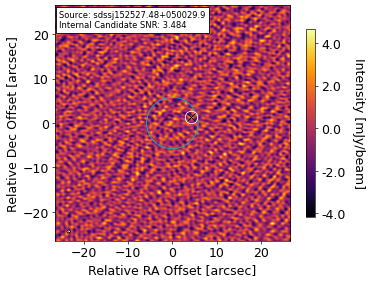

In [21]:
summary('../data/sdssj152527.48+050029.9.fits')

will make below a function
maybe "detection_image"?
argument is peak coords

In [22]:
fits_file = '../data/sdssj152527.48+050029.9.fits' # change this to actual path for testing

##### BELOW IS COPIED FROM region_stats #####
i = fits_data_index(fits_file)

# open FITS file
try:
    file = fits.open(fits_file)
except:
    print(f'Unable to open {fits_file}')

# extract data array
info = file[i]
data = info.data

##### STARTING NEW-ISH STUFF #####
data_array = data[0]

header_data = fits.getheader(fits_file)

pixel_scale = Angle(header_data['CDELT1'], header_data['CUNIT1']).to_value('arcsec') / u.arcsec
x_dim = header_data['NAXIS1']
y_dim = header_data['NAXIS2']

center = (round(x_dim/2), round(y_dim/2))

##### MADE THIS UP FOR TESTING PURPOSES #####
peak_coords = (4.157787343125113, 1.2599355585227614) # normalized peak coordinates, will be an argument

##### CONTINUING MY CODE #####
# unnormalized the normalized coordinates
unnorm_x = round((peak_coords[0] / pixel_scale).value + center[0])
unnorm_y = round((peak_coords[1] / pixel_scale).value + center[1])

delta = math.ceil(2.5 / pixel_scale.value) # ~number of pixels in 2.5 arcsec

# make sure the ~5x5 arcsec box is actually inside the original image and handle issues if not
new_data = data_array
if unnorm_y - delta >= 0:
    new_data = data_array[unnorm_y - delta:]
if unnorm_y + delta < y_dim:
    new_data = new_data[:(unnorm_y + delta) - y_dim + 1]
if unnorm_x - delta >= 0:
    new_data = [row[unnorm_x - delta:] for row in new_data]
if unnorm_x + delta < x_dim:
    new_data = [row[:(unnorm_x + delta) - x_dim + 1] for row in new_data]

y_length = len(new_data)
if y_length == 0:
    raise ValueError("Attempts to obtain a smaller image centered on the source resulted in an empty data array.")
else:
    x_length = len(new_data[0])

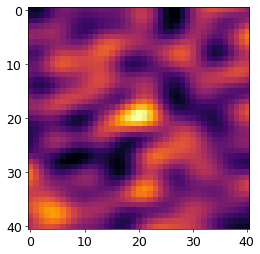

In [23]:
plt.imshow(new_data)

In [24]:
# slices (1x each direction) of original data array to get our box

IMPORTANT: data[y][x]

In [25]:
# x_coords.append((ext_peak_coords[i][0] - center[0]) * pixel_scale)

In [26]:
sampled_values = {} # dictionary of sampled data points

Should test to decide how "finely" I want to interpolate things

arguments:
- peak coords (normalized)
- pixel scale
- x-axis length
- y-axis length
- fits file path

In [27]:
def interpolated_value(x):
    # TODO: assert k between -1 and N + 1
    # TODO: find x_k and x_k+1 s.t. x_k <= x <= x_k+1
    # TODO: grab c values from dictionary
    # TODO: plug everything into interpolation function
    # TODO: return value
    pass